# Проект: определение возраста человека по фото

**Цель:**

* обучить модель, которая сможет оценивать возраст посетителей супермаркета по внешности, чтобы предлагать потенциально интересные товары и контролировать соблюдение кассирами запрета на продажу алкоголя несовершеннолетним.

Для решения задачи компьютерного зрения будем использовать нейросети, так как изображения содержат слишком большое количество признаков, чтобы работать с ними при помощи классических алгоритмов.

## Исследовательский анализ данных

In [4]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

Посмотрим на то, какие у нас имеются данные.

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


* У нас есть датафрейм, в котором содержится информация о фотографиях и возрасте людей, изображённых на них.
* Первый столбец содержит имя файла, а второй - целевой признак, возраст.

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


* В датасете 7591 объект.
* Пропусков нет.
* Типы данных вполне соответствуют тем признакам, которые они описывают.

Посмотрим на то, какое распределение имеет возраст.

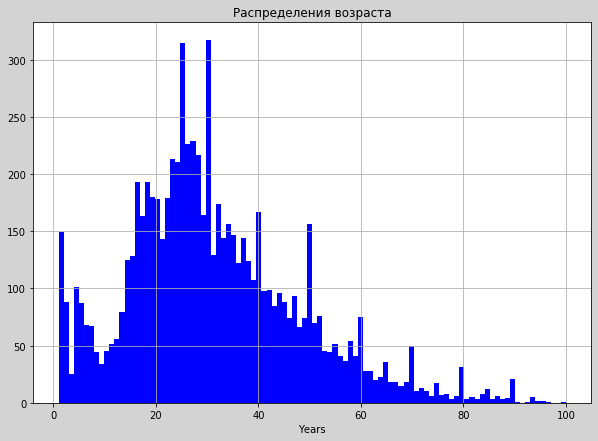

In [7]:
#Построимграфик распределения возраста в выборке.
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(labels['real_age'], color = 'blue', bins=100)
plt.title('Распределения возраста')
plt.xlabel('Years')
fig.set_facecolor('lightgrey')
ax.set_facecolor('white')
plt.grid()
plt.show()

* Данные по возрасту имеют правостороннюю ассиметрию. 
* Имеются пики по определенным возрастам (5, 25 и 30 лет). Т.е. в данной выборке имеется перевес фотографий людей средних и младших возрастов. Что может быть минусом для обученной модели, могу предположить, что она будет хуже предсказывать возраст людей старшего поколения.

**Загрузим и посмотрим на фотографии из обучающей выборки.**

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


* Загрузили имеющиеся данные. Количество фотографий - 7591. Считаю, что такого количества фотографий недостаточно для хорошего обучения модели, было бы здорово получить еще хотя бы 50 тысяч дополнительно (с учетом  того, что на земле 7,5 млрд. человек со своими особенностями лица).
* Так как данных мало нам на помощь приходит уже предобученная нейросеть ResNet50

In [9]:
#Посмотрим на размер выборки (одного батча)
features, target = next(gen_flow)
print(features.shape)

(32, 224, 224, 3)


* В одном батче содержится 32 изображения размеров 224 на 224 пикселей с 3-мя каналами (RGB)

Напечатаем на экране первые 16 фотографий

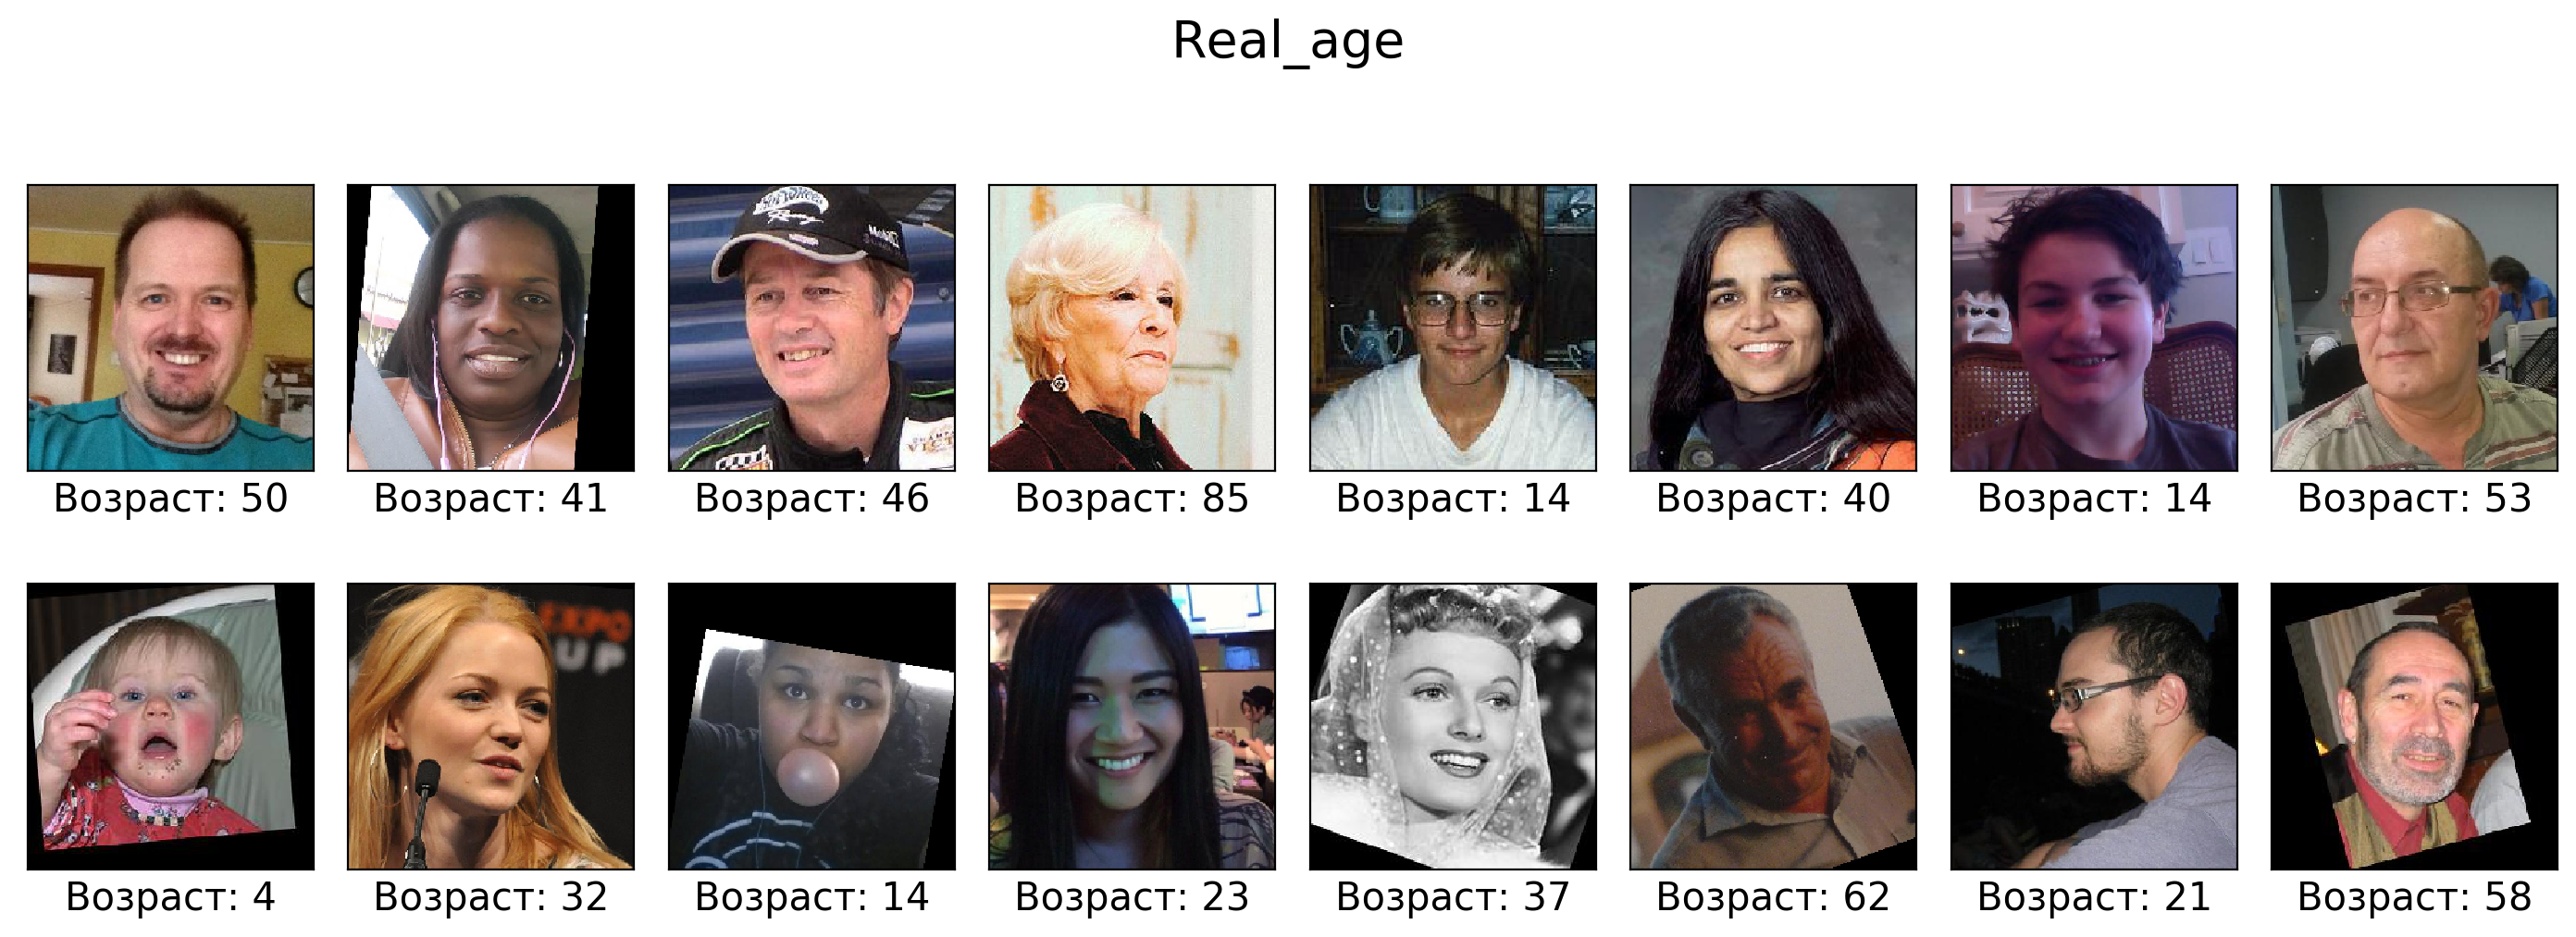

In [26]:
fig = plt.figure(figsize=(14, 5), dpi=200)
for i in range(16):
    fig.add_subplot(2, 8, i+1)
    fig.suptitle('Real_age', y = 1.05, fontsize = 20)
    plt.imshow(features[i])
    plt.xlabel(f'Возраст: {target[i]}',
              fontsize = 15)
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=1)

Видим самые разные фотографии:

* с разными цветовыми характеристиками (даже чёрно-белые);
* на фото изображены люди по одному на каждом;
* в основном изображен бюст;
* можно отметить что люди на фото улыбаются.


В качестве аугментации можно попробовать увеличить размер лица, сделать изображение более светлым, добавить резкости  и флип, так как не которые люди изображены впрофиль.

## 2. Обучение модели

Мы не будем обучать модель здесь, а просто скопируем код, который задаёт её параметры. Сама модель будет обучена на GPU отдельно.  

*Поэтому далее отразим код в текстовой ячейке.*

* В качестве модели мы испытаем архитектуру ResNet50, предобученную на базе ImageNet.
* Верхушкой нашей модели будет полносвязный слой с одним нейроном: для предсказания единственного значения этого достаточно.
* Мы выставили количество эпох, равное 10: опытным путём мы установили, что примерно такого значения достаточно, чтобы получить отличное качество при валидации.
* В качестве функции потерь зададим MSE.
* Мы попробовали разные значения скорости обучения и выяснили, что значение 0.0001 вполне нам подходит, поскольку при длительном обучении и большем learning rate функция потерь начинает "застревать" и колебаться между похожими значениями - а значит, ходить кругами вокруг минимума, но не попадать в него.

```python

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)  
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
    
```

**Вывод обучения**

```
Found 5694 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 113s - loss: 224.4690 - mae: 10.6688 - val_loss: 635.9404 - val_mae: 20.2200
Epoch 2/10
178/178 - 41s - loss: 55.1423 - mae: 5.6298 - val_loss: 717.7619 - val_mae: 21.6830
Epoch 3/10
178/178 - 41s - loss: 26.5234 - mae: 3.9326 - val_loss: 203.8967 - val_mae: 10.4671
Epoch 4/10
178/178 - 41s - loss: 17.7984 - mae: 3.2222 - val_loss: 124.2105 - val_mae: 8.3656
Epoch 5/10
178/178 - 41s - loss: 12.8321 - mae: 2.7049 - val_loss: 82.5024 - val_mae: 6.7869
Epoch 6/10
178/178 - 41s - loss: 10.4539 - mae: 2.4413 - val_loss: 78.5995 - val_mae: 6.8533
Epoch 7/10
178/178 - 41s - loss: 8.7770 - mae: 2.2252 - val_loss: 68.1304 - val_mae: 6.2648
Epoch 8/10
178/178 - 41s - loss: 7.5302 - mae: 2.0767 - val_loss: 66.4976 - val_mae: 6.1303
Epoch 9/10
178/178 - 41s - loss: 6.8069 - mae: 1.9705 - val_loss: 67.4522 - val_mae: 6.1727
Epoch 10/10
178/178 - 41s - loss: 6.2221 - mae: 1.8597 - val_loss: 67.0034 - val_mae: 6.2081

60/60 - 10s - loss: 67.0034 - mae: 6.2081
Test MAE: 6.2081
```

Достигли МАЕ = 6.2, что удовлетворяет условию задачи.

## Анализ обученной модели

С целью получения наилучшего качества модели на данной нам выборке, необходимо использовать количество эпох не менее 5. А также было бы здорово обучить модель на выборке большего размера (с бОльшим количеством фото). Плюсом для обучения было бы использование примерно одинакового количества фотографий каждого возраста, а пока что наблюдает дисбаланс, и модель может не определить возраст 70-ти летнего человека.

**Средняя ошибка модели равна 6,2. Что это может значить?**

* Если мы предложим модели назвать возраст ребёнка на фотографии, то она вряд ли перепутает его с пожилым человеком.
* Сложно сказать, на людях каких возрастов модель ошибается больше всего. У нас нет возможности посмотреть на предсказания в силу реализации обучения, но если бы они у нас имелись, то мы могли бы категоризовать фотографии по возрасту и найти ошибку для каждой категории.
* Работу модели могут портить сами люди с фотографий: некоторые люди выглядят значительно старше своего возраста, другие - наоборот, вечно молодые.

**Какая польза от модели для бизнеса?**

* Если мы имеем ошибку в 6 лет, то бизнесу придется спрашивать паспорт для проверки возраста при продаже алкоголя.
* А вот для рекомендации товара, разница в 6 лет некритична, чтобы разбить людей на категориии (подросток, молодеж, зрелые, пенсионеры) и по набору товаров из чека предлагать необохдимое для нуной категории.